In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('shopping_trends.csv')
train_df = df.iloc[:3000]
update_df = df.iloc[3000:]

In [3]:
class BayesianCustomerClassifier:
    def __init__(self):
        self.priors = {}  # lưu xác suất prior cho mỗi tần suất mua hàng
        self.feature_means = {}  # lưu mean của features cho mỗi tần suất
        self.feature_stds = {}   # lưu std của features cho mỗi tần suất
        self.features = ['Age', 'Purchase Amount (USD)', 'Previous Purchases']
        
    def fit(self, data):
        # Tính P(Frequency) - tỷ lệ mỗi loại tần suất mua hàng
        self.priors = data['Frequency of Purchases'].value_counts(normalize=True).to_dict()
        
        # Tính mean và std của features cho mỗi frequency
        for freq in self.priors.keys():
            mask = data['Frequency of Purchases'] == freq
            self.feature_means[freq] = data[mask][self.features].mean().to_dict()
            self.feature_stds[freq] = data[mask][self.features].std().to_dict()
   
    def calculate_likelihood(self, x, freq):
        likelihood = 1.0
        for feature in self.features:
            mean = self.feature_means[freq][feature]
            std = self.feature_stds[freq][feature]
            # Công thức Gaussian PDF
            likelihood *= (1/(std * np.sqrt(2*np.pi))) * \
                        np.exp(-0.5*((x[feature] - mean)/std)**2)
        return likelihood
   
    def predict_proba(self, x):
       likelihoods = {
           freq: self.calculate_likelihood(x, freq) * prior 
           for freq, prior in self.priors.items()
       }
       total = sum(likelihoods.values())
       return {freq: prob/total for freq, prob in likelihoods.items()}
   
    def update(self, new_data):
       # Update priors with new data
       new_priors = new_data['Frequency of Purchases'].value_counts(normalize=True).to_dict()
       total_samples = len(train_df) + len(new_data)
       
       for freq in self.priors.keys():
           self.priors[freq] = (self.priors[freq] * len(train_df) + 
                               new_priors.get(freq, 0) * len(new_data)) / total_samples
           
       # Update feature statistics
       for freq in self.priors.keys():
           mask = new_data['Frequency of Purchases'] == freq
           if mask.any():
               # Update means
               old_mean = pd.Series(self.feature_means[freq])
               new_mean = new_data[mask][self.features].mean()
               n1 = len(train_df[train_df['Frequency of Purchases'] == freq])
               n2 = mask.sum()
               updated_mean = (old_mean * n1 + new_mean * n2) / (n1 + n2)
               self.feature_means[freq] = updated_mean.to_dict()
               
               # Update standard deviations
               old_std = pd.Series(self.feature_stds[freq])
               new_std = new_data[mask][self.features].std()
               updated_std = np.sqrt(((n1-1)*old_std**2 + (n2-1)*new_std**2)/(n1+n2-1))
               self.feature_stds[freq] = updated_std.to_dict()


In [5]:
def analyze_data(df):
   print("Basic Statistics:")
   print(df[['Age', 'Purchase Amount (USD)', 'Previous Purchases']].describe())
   
   print("\nFrequency Distribution:")
   print(df['Frequency of Purchases'].value_counts(normalize=True))
   
   # Visualizations
   fig, axes = plt.subplots(2, 2, figsize=(15, 10))
   
   # Age distribution
   sns.histplot(data=df, x='Age', hue='Frequency of Purchases', ax=axes[0,0])
   axes[0,0].set_title('Age Distribution by Purchase Frequency')
   
   # Purchase amount distribution
   sns.boxplot(data=df, x='Frequency of Purchases', y='Purchase Amount (USD)', ax=axes[0,1])
   axes[0,1].set_title('Purchase Amount by Frequency')
   
   # Previous purchases
   sns.scatterplot(data=df, x='Previous Purchases', y='Purchase Amount (USD)', 
                   hue='Frequency of Purchases', ax=axes[1,0])
   axes[1,0].set_title('Previous Purchases vs Amount')
   
   # Correlation heatmap
   numeric_cols = ['Age', 'Purchase Amount (USD)', 'Previous Purchases']
   sns.heatmap(df[numeric_cols].corr(), annot=True, ax=axes[1,1])
   axes[1,1].set_title('Feature Correlations')
   
   plt.tight_layout()
   plt.show()

Initial Data Analysis:
Basic Statistics:
               Age  Purchase Amount (USD)  Previous Purchases
count  3000.000000            3000.000000         3000.000000
mean     44.059667              59.649333           25.642000
std      15.284239              23.797223           14.411745
min      18.000000              20.000000            1.000000
25%      31.000000              38.000000           13.000000
50%      44.000000              60.000000           25.500000
75%      57.000000              81.000000           38.000000
max      70.000000             100.000000           50.000000

Frequency Distribution:
Frequency of Purchases
Every 3 Months    0.151667
Annually          0.146333
Quarterly         0.145667
Monthly           0.140667
Fortnightly       0.140000
Weekly            0.139000
Bi-Weekly         0.136667
Name: proportion, dtype: float64


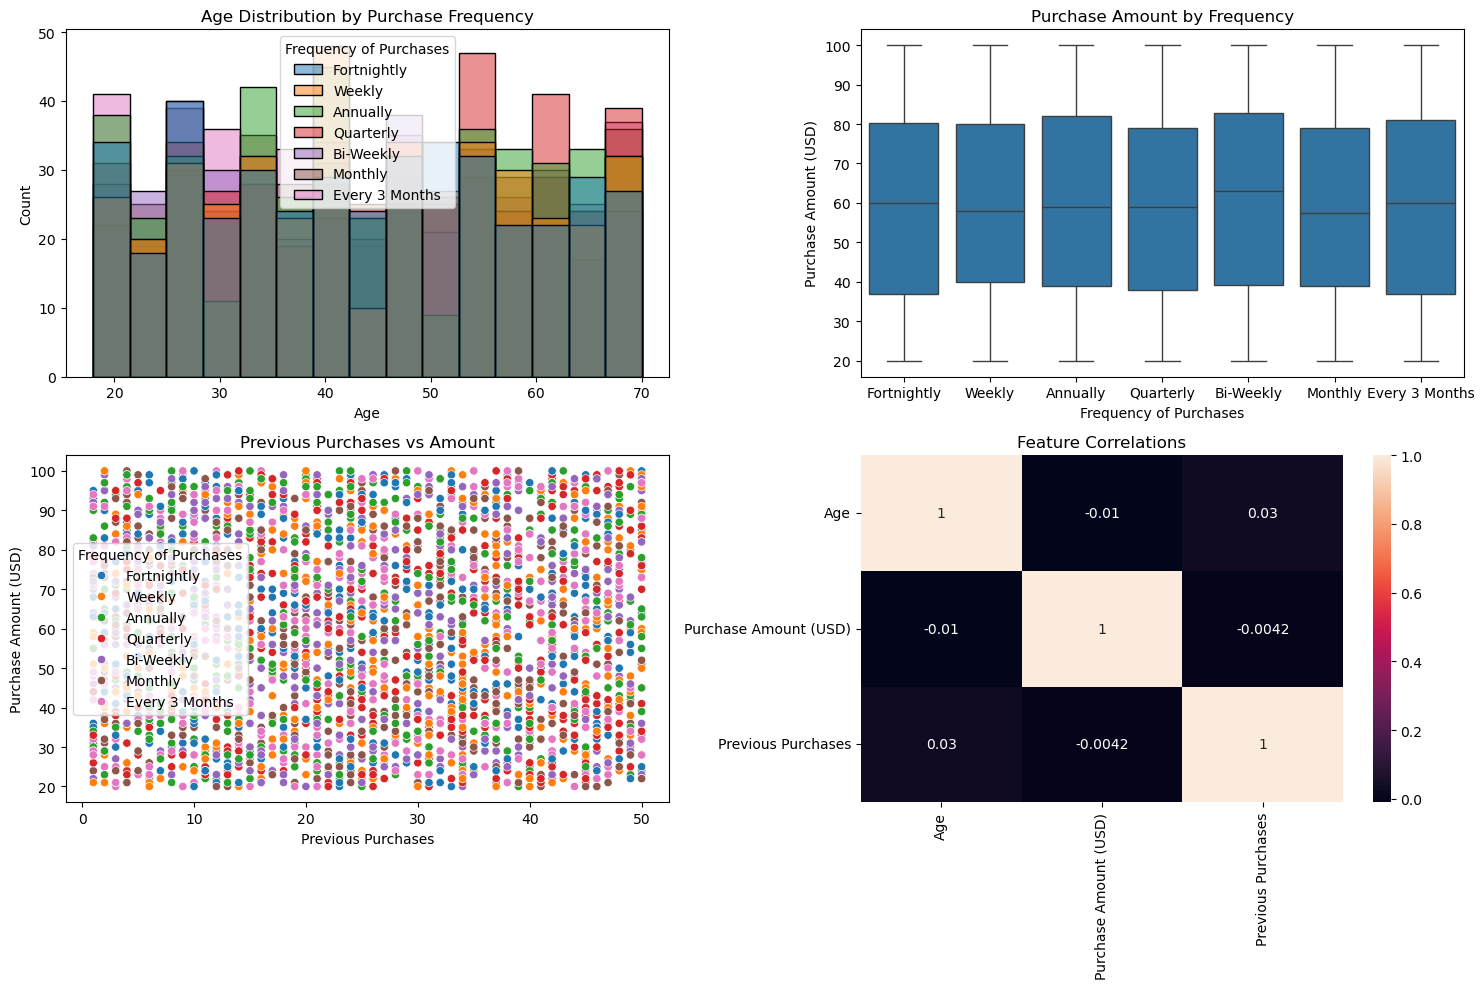


Initial Prediction: {'Every 3 Months': 0.17036613562736855, 'Annually': 0.1621776598898477, 'Quarterly': 0.12493905312333507, 'Monthly': 0.12126523011458475, 'Fortnightly': 0.1440624537347909, 'Weekly': 0.11432413156320365, 'Bi-Weekly': 0.16286533594686953}

Updated Prediction: {'Every 3 Months': 0.17279845276752495, 'Annually': 0.15600792796413757, 'Quarterly': 0.12398057226354359, 'Monthly': 0.1255355904920623, 'Fortnightly': 0.13672012468614478, 'Weekly': 0.11753504581872985, 'Bi-Weekly': 0.16742228600785683}

Model Comparison after Update:
Basic Statistics:
              Age  Purchase Amount (USD)  Previous Purchases
count  900.000000             900.000000          900.000000
mean    44.097778              60.147778           24.383333
std     14.957611              23.317734           14.530576
min     18.000000              20.000000            1.000000
25%     31.000000              40.000000           12.000000
50%     45.000000              60.000000           24.000000
75% 

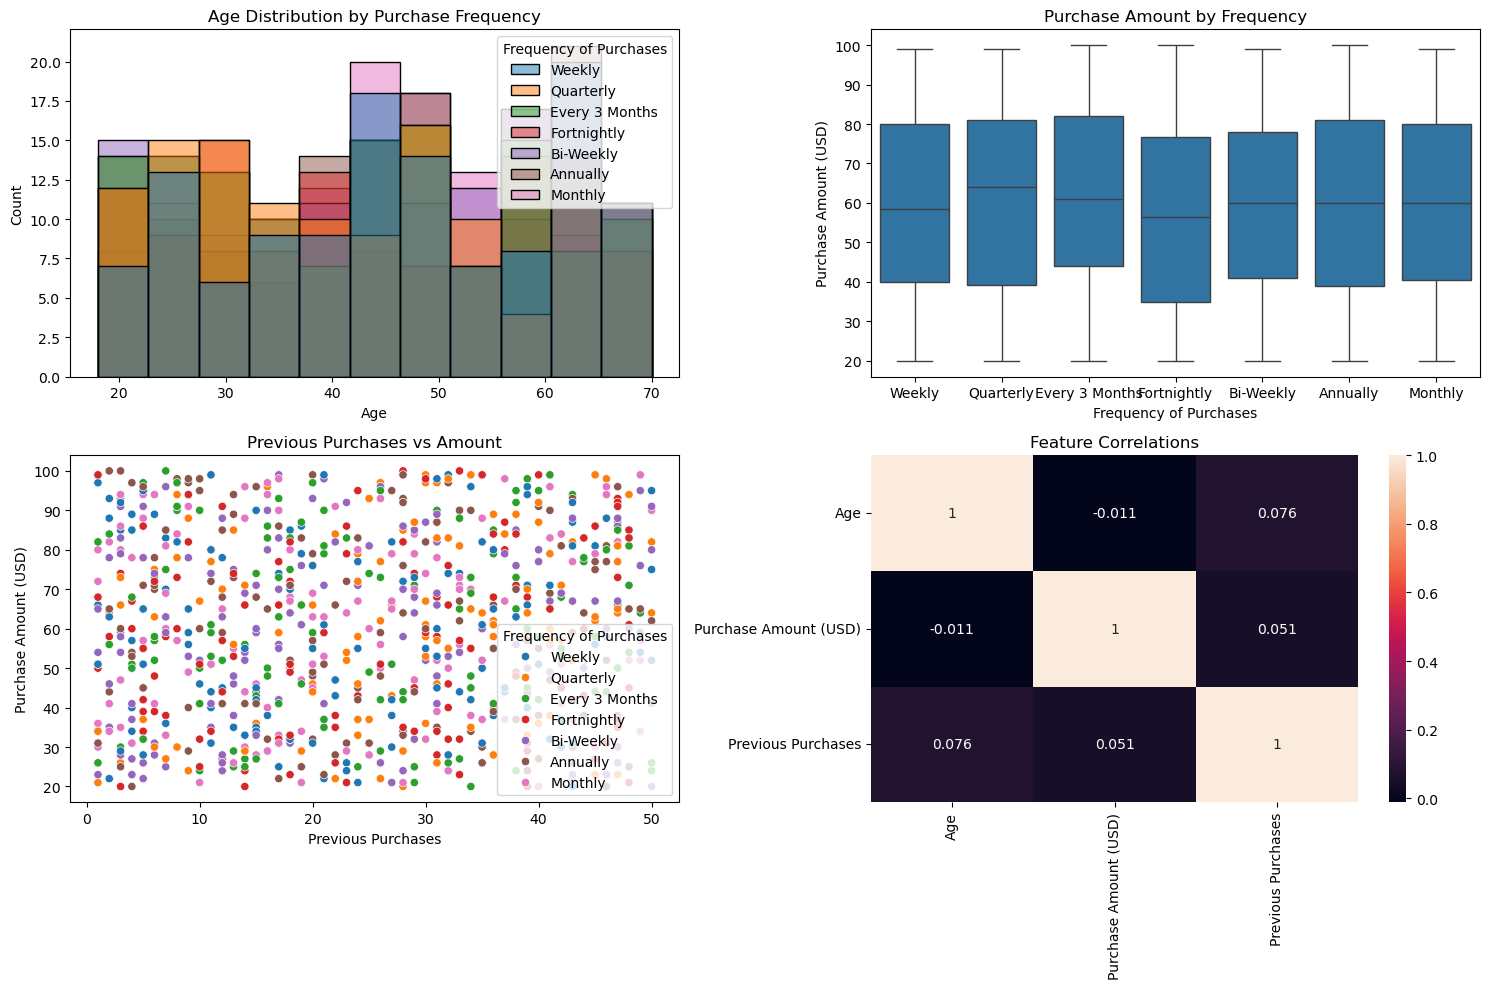

In [6]:
def main():
   # Analyze initial data
   print("Initial Data Analysis:")
   analyze_data(train_df)
   
   # Train model
   model = BayesianCustomerClassifier()
   model.fit(train_df)
   
   # Test prediction
   test_customer = {
       'Age': 30,
       'Purchase Amount (USD)': 100,
       'Previous Purchases': 5
   }
   print("\nInitial Prediction:", model.predict_proba(test_customer))
   
   # Update model with new data
   model.update(update_df)
   print("\nUpdated Prediction:", model.predict_proba(test_customer))
   
   # Compare predictions
   print("\nModel Comparison after Update:")
   analyze_data(update_df)

if __name__ == "__main__":
   main()